In [1]:
from ipywidgets import interact, fixed

%matplotlib inline

## PyINS Convention

A direction cosine matrix from heading, pitch and roll angles

By definition :
${C}_{nb} = \left[
\begin{array}{ccc}
\left[ \overrightarrow{x_b}\right]_{[n]} & \left[
\overrightarrow{y_b}\right]_{[n]} & \left[
\overrightarrow{z_b}\right]_{[n]}
\end{array}
\right].$ 

One way to define this matrix is the Euler angles, the convention chosen in PyINS is this sequence of elemental rotations as follows:

${\LARGE N \stackrel{\text{-heading}}{\longrightarrow}  \stackrel{\text{pitch}}  {\longrightarrow} \stackrel{\text{roll}}{\longrightarrow}}  \LARGE B$

Let's choose the heading h, pitch p and roll r in degrees, compute and plot the direction cosine matrix **B**ody frame to **N**avigation frame :

In [2]:
from pyins import dcm
from helper import plot_nb

In [3]:
def f(h, p, r):
    Cnb = dcm.from_hpr(h, p, r)
    plot_nb(Cnb)

interact(f, h=(-180,180), p =(-180,180), r=(-180,180), continuous_update=False)

interactive(children=(IntSlider(value=0, description='h', max=180, min=-180), IntSlider(value=0, description='…

<function __main__.f(h, p, r)>

## Use of the 3-axis turntable 

Selection of a 100Hz frequency : 

In [4]:
dt = 1/100

### Creating a sequence

Select $N = B$ to start :

In [5]:
h0, p0, r0 = 0, 0, 0 

Calling the TableRotations object, by default the rest time is 20 seconds and the speed of rotation is 10 °/s

In [6]:
from pyins import sim

In [7]:
Table = sim.TableRotations(dt, h0, p0, r0)

We start with an rest of 5s :

In [8]:
Table.rest(5)

Then a 90° rotation around $x_n$ at the default rotation speed :

In [9]:
Table.rotate(0, 90)

Then a default rest:

In [10]:
Table.rest()

Then a -90° rotation around $y_n$ at 20°/s :

In [11]:
Table.rotate(1, -90, 20)

Then a default rest:

In [12]:
Table.rest()

Then a 90° rotation around $z_n$ at the default rotation speed :

In [13]:
Table.rotate(2, 90)

Then a default rest:

In [14]:
Table.rest()

And so on... Next time, we'll do a loop for !

We can visualize the sequence thanks to [Jupiter's interact](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) function :

In [15]:
def f(t_s, dt, Cnb):
    n = int(t_s/dt)
    plot_nb(Cnb[n,:,:])
    
tf = Table.Cnb.shape[0]*dt
interact(f, t_s = (0, tf), Cnb = fixed(Table.Cnb), dt = fixed(dt), continuous_update=False)

interactive(children=(FloatSlider(value=43.755, description='t_s', max=87.51), Output()), _dom_classes=('widge…

<function __main__.f(t_s, dt, Cnb)>

### Generate inertial readings

We have to choose the position of the table e.g. Paris :

In [16]:
lat_Paris = 48.8534  # degrees
alt_Paris = 35       # meters

Longitude doesn't matter here, the earth is modeled by an ellipsoid of revolution.

Then we generate the inertial measurements :

In [17]:
gyros, accels = sim.stationary_rotation(dt, lat_Paris, alt_Paris, Table.Cnb)

The inertial readings are drawn below:

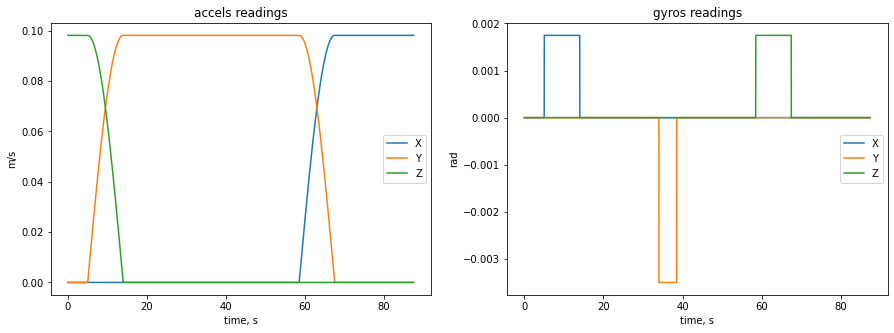

In [18]:
from helper import plot_inertial_readings

plot_inertial_readings(dt, gyros, accels)

### Integrating IMU data

In [19]:
lon_Paris = 2.3488  # degrees 

In [20]:
from pyins.integrate import coning_sculling, integrate
theta, dv = coning_sculling(gyros, accels)
VE0 = 0
VN0 = 0
traj_ideal = integrate(dt, lat_Paris, lon_Paris, VE0, VN0, h0, p0, r0, theta, dv)

In [21]:
traj_ideal

,lat,lon,VE,VN,h,p,r
stamp,,,,,,,
0,48.8534,2.3488,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,48.8534,2.3488,-6.668294e-13,1.550569e-08,0.000000e+00,2.287433e-15,3.193851e-20
2,48.8534,2.3488,-2.557708e-13,3.687227e-08,0.000000e+00,3.052134e-15,6.227064e-20
3,48.8534,2.3488,-3.841645e-13,4.651708e-08,0.000000e+00,6.801423e-15,9.866920e-20
4,48.8534,2.3488,-2.181727e-13,9.718810e-08,0.000000e+00,1.485286e-14,9.866920e-20
...,...,...,...,...,...,...,...
8746,48.8534,2.3488,3.937924e-08,8.096269e-06,3.839611e-12,3.241011e-09,-9.000000e+01
8747,48.8534,2.3488,3.930481e-08,8.072980e-06,3.843641e-12,3.241741e-09,-9.000000e+01
8748,48.8534,2.3488,3.944558e-08,8.094396e-06,3.847669e-12,3.242465e-09,-9.000000e+01
